In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from scipy.stats import spearmanr
from statsmodels.graphics.tsaplots import plot_acf
import itertools
from itertools import product
import warnings
warnings.filterwarnings('ignore')  # 关闭所有警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [17]:
# 读取 Excel 文件
file_path = 'data.xlsx'

# 查看文件内所有sheet名，确认需要读取的sheet
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)

Sheet names: ['收盘价', '自由流通换手率']


In [18]:
# 读取 sheet1
df = pd.read_excel(file_path, sheet_name='收盘价')

In [19]:
# 将第一列（日期列）重命名为 'date'
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# 将 'date' 转换为 datetime 格式
df['date'] = pd.to_datetime(df['date'])

# 设置为 index
df = df.set_index('date')

# 检查结果
print(df.head())
print(df.index)

               50收益  中证1000全收益     800收益
date                                    
2005-01-04  835.130    989.984  983.8953
2005-01-05  839.529   1013.583  995.5764
2005-01-06  830.513   1005.466  986.2162
2005-01-07  831.641   1011.740  987.6929
2005-01-10  841.102   1023.638  997.1864
DatetimeIndex(['2005-01-04', '2005-01-05', '2005-01-06', '2005-01-07',
               '2005-01-10', '2005-01-11', '2005-01-12', '2005-01-13',
               '2005-01-14', '2005-01-17',
               ...
               '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
               '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25',
               '2025-06-26', '2025-06-27'],
              dtype='datetime64[ns]', name='date', length=4974, freq=None)


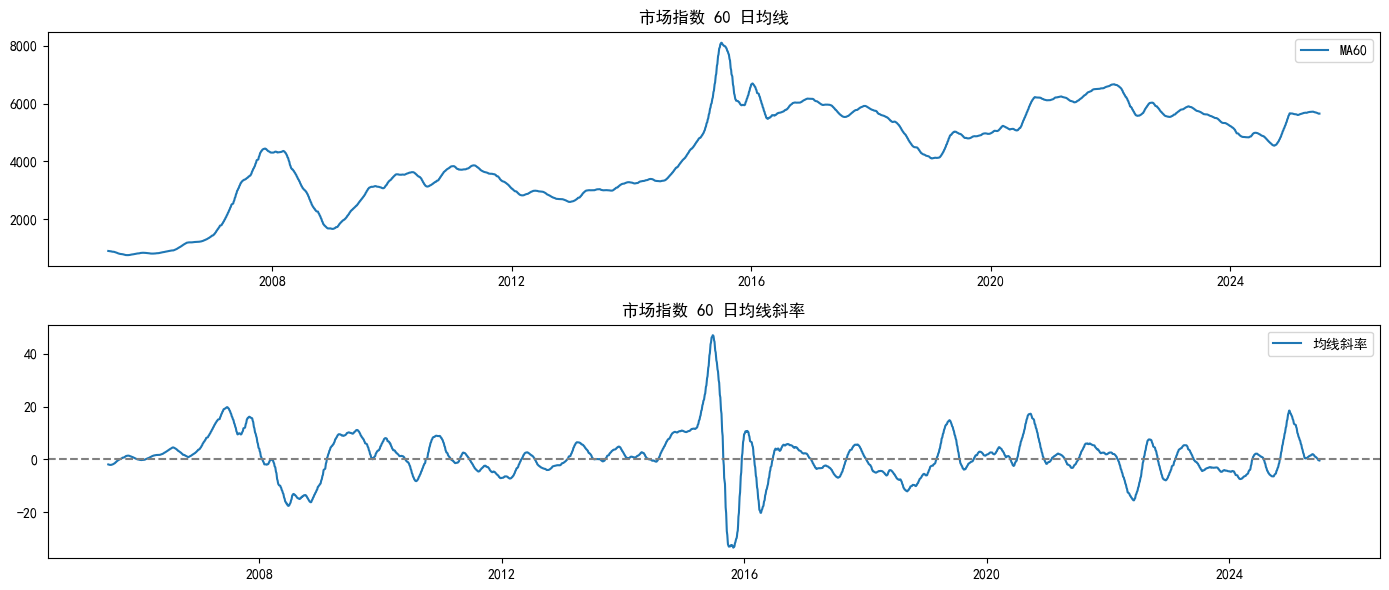

In [20]:
def plot_ma_slope(df, ma_window=60):
    """
    计算并绘制市场指数均线及其斜率变化

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - ma_window: int，均线窗口期
    """

    # === 1) 构造市场指数（这里取大盘和小盘平均，可根据需要改为中证800或其他基准）
    market_index = (df['50收益'] + df['中证1000全收益']) / 2

    # === 2) 计算均线
    ma = market_index.rolling(ma_window).mean()

    # === 3) 计算均线斜率
    ma_shifted = ma.shift(ma_window)
    slope = (ma - ma_shifted) / ma_window

    # === 4) 绘图
    plt.figure(figsize=(14,6))

    # 绘制均线
    plt.subplot(2,1,1)
    plt.plot(df.index, ma, label=f'MA{ma_window}')
    plt.title(f'市场指数 {ma_window} 日均线')
    plt.legend()

    # 绘制斜率
    plt.subplot(2,1,2)
    plt.plot(df.index, slope, label='均线斜率')
    plt.axhline(0, color='grey', linestyle='--')
    plt.title(f'市场指数 {ma_window} 日均线斜率')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return slope

# === 调用示例 ===

slope_series = plot_ma_slope(df, ma_window=60)

## 反转策略

反转基准策略

In [21]:
def reversal_strategy_monthly(df, window=30, min_large_weight=0.9):
    """
    纯反转大小盘切换策略（月度调仓版）

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - window: int，计算反转信号的窗口期
    - min_large_weight: float，大盘最小配置比例

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # === 1) 计算过去window日收益率 ===
    r_50 = df['50收益'].pct_change(periods=window)
    r_1000 = df['中证1000全收益'].pct_change(periods=window)

    # === 2) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 3) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始默认仓位
    current_pos_50 = min_large_weight
    current_pos_1000 = 1 - min_large_weight

    # === 4) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:
            if (r_1000.loc[date] < r_50.loc[date]):  # 小盘近期弱 ➔ 买入小盘
                current_pos_50 = 0
                current_pos_1000 = 1
            else:  # 小盘近期强 ➔ 买入大盘
                current_pos_50 = 1
                current_pos_1000 = 0

            # 归一化
            total = current_pos_50 + current_pos_1000
            current_pos_50 /= total
            current_pos_1000 /= total

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

回测

In [22]:
# 获取策略每日仓位
position_df = reversal_strategy_monthly(df)

# =============================
# 计算每日组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# =============================
# 计算净值与超额净值曲线
# =============================
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出结果
# =============================
print(f"【回测指标】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")

【回测指标】
年化收益率: 12.31%
年化波动率: 27.64%
夏普比率: 0.45
最大回撤: -67.25%
Calmar Ratio: 0.18


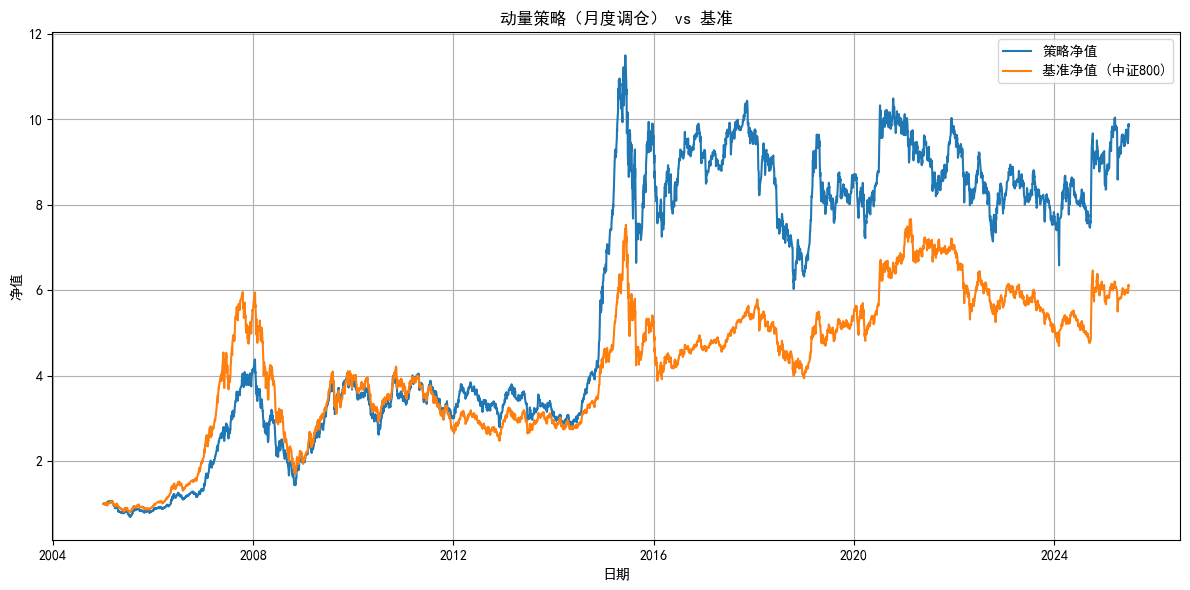

In [23]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('动量策略（月度调仓） vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

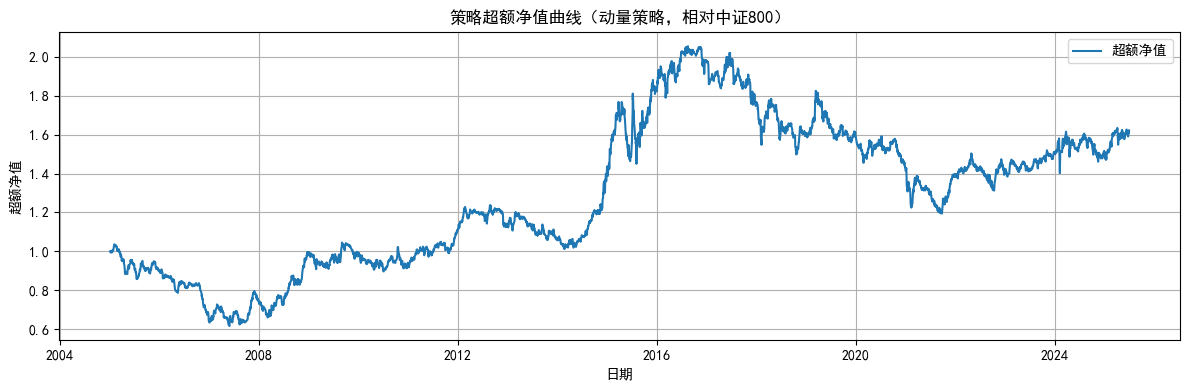

In [24]:
# 绘制超额净值曲线
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('策略超额净值曲线（动量策略，相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# =============================
# 数据切分
# =============================

split_index_train = int(len(df) * 0.65)
split_index_val = int(len(df) * 0.8)

df_train = df.iloc[:split_index_train]
df_val = df.iloc[split_index_train:split_index_val]  # 验证集（测试集1）
df_test = df.iloc[split_index_val:]  # 测试集2

# =============================
# 参数范围
# =============================

window_range = [5, 10, 20, 30, 40, 50, 60]
min_large_weight_range = [0.5, 0.6, 0.7, 0.8, 0.9]

# =============================
# Grid Search on Training Set
# =============================

results = []

for window, min_large_weight in itertools.product(window_range, min_large_weight_range):
    
    # 获取策略仓位（在训练集上）
    position_df = reversal_strategy_monthly(
        df_train,
        window=window,
        min_large_weight=min_large_weight
    )
    
    # 计算组合收益率
    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    
    # 计算净值曲线
    portfolio_nav = (1 + portfolio_returns).cumprod()
    
    # 计算指标
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 存储结果
    results.append({
        'window': window,
        'min_large_weight': min_large_weight,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出 Top 10
# =============================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))

【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
    window  min_large_weight  annual_return  annual_vol  sharpe_ratio  \
19      30               0.9       0.186599    0.299524      0.622984   
18      30               0.8       0.186421    0.299531      0.622376   
17      30               0.7       0.186242    0.299543      0.621753   
16      30               0.6       0.186061    0.299560      0.621113   
15      30               0.5       0.185878    0.299582      0.620456   
34      60               0.9       0.174480    0.298490      0.584542   
33      60               0.8       0.174304    0.298496      0.583940   
32      60               0.7       0.174126    0.298509      0.583322   
31      60               0.6       0.173947    0.298526      0.582688   
30      60               0.5       0.173766    0.298548      0.582038   

    max_drawdown  calmar_ratio  
19     -0.672497      0.277471  
18     -0.672497      0.277207  
17     -0.672497      0.276941  
16     -0.672497      0.2766

In [26]:
# =============================
# 验证集（测试集1）评估
# =============================

best_params = results_df_sorted.iloc[0]

position_val = reversal_strategy_monthly(
    df_val,
    window=int(best_params['window']),
    min_large_weight=best_params['min_large_weight']
)

returns_50_val = df_val['50收益'].pct_change()
returns_1000_val = df_val['中证1000全收益'].pct_change()
portfolio_returns_val = position_val['position_50'] * returns_50_val + position_val['position_1000'] * returns_1000_val
portfolio_returns_val = portfolio_returns_val.fillna(0)
portfolio_nav_val = (1 + portfolio_returns_val).cumprod()

annual_return_val = portfolio_nav_val.iloc[-1] ** (252 / len(portfolio_nav_val)) - 1
annual_vol_val = portfolio_returns_val.std() * np.sqrt(252)
sharpe_ratio_val = annual_return_val / annual_vol_val
max_drawdown_val = (portfolio_nav_val / portfolio_nav_val.cummax() - 1).min()
calmar_ratio_val = annual_return_val / abs(max_drawdown_val)

print("\n【验证集（测试集1）表现】")
print(f"年化收益率: {annual_return_val:.2%}")
print(f"年化波动率: {annual_vol_val:.2%}")
print(f"夏普比率: {sharpe_ratio_val:.2f}")
print(f"最大回撤: {max_drawdown_val:.2%}")
print(f"Calmar Ratio: {calmar_ratio_val:.2f}")


【验证集（测试集1）表现】
年化收益率: 5.45%
年化波动率: 23.64%
夏普比率: 0.23
最大回撤: -25.15%
Calmar Ratio: 0.22


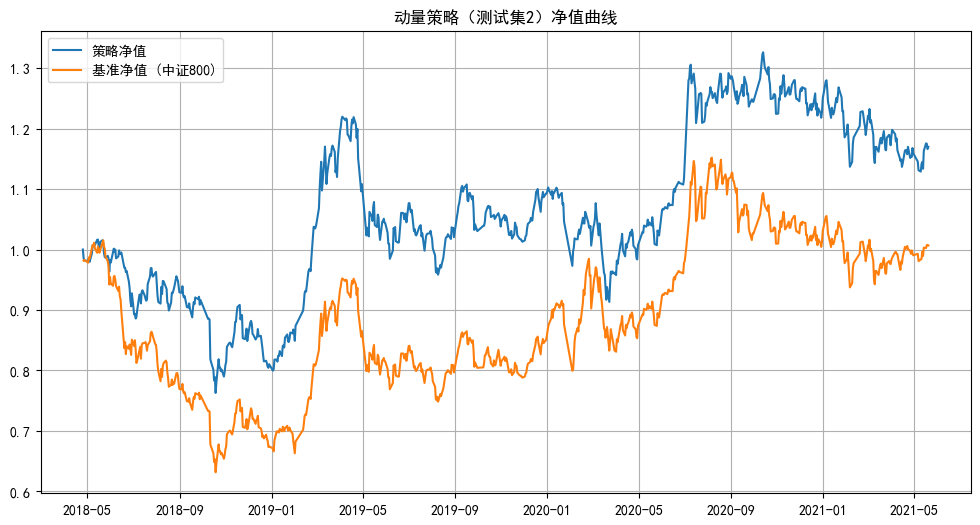

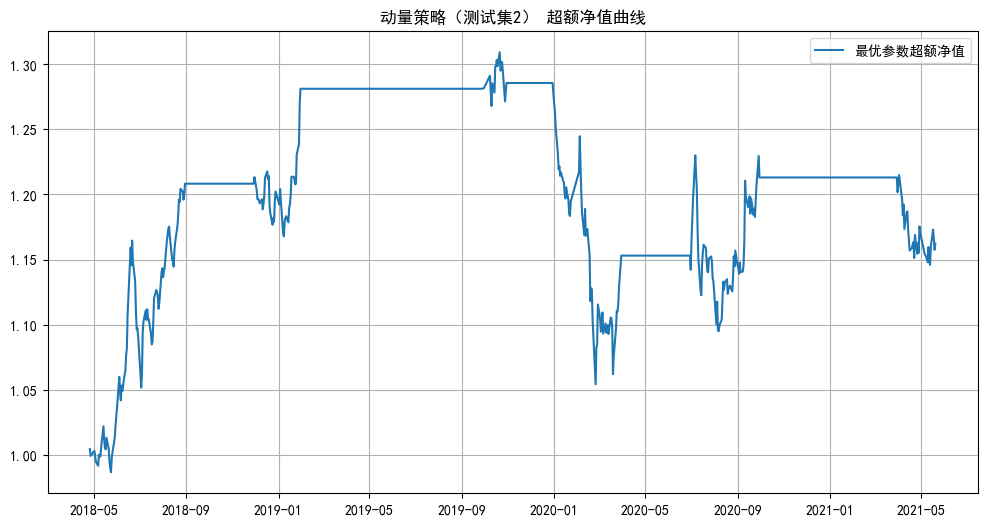

In [27]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_val = (1 + returns_1000_val).cumprod()

# 计算超额净值曲线
excess_nav_val = portfolio_nav_val / benchmark_nav_val


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_val.index, portfolio_nav_val, label='策略净值')
plt.plot(benchmark_nav_val.index, benchmark_nav_val, label='基准净值 (中证800)')
plt.title('动量策略（测试集2）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_val.index, excess_nav_val, label='最优参数超额净值')
plt.title('动量策略（测试集2） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# =============================
# 测试集2 评估
# =============================

position_test2 = reversal_strategy_monthly(
    df_test,
    window=int(best_params['window']),
    min_large_weight=best_params['min_large_weight']
)

returns_50_test2 = df_test['50收益'].pct_change()
returns_1000_test2 = df_test['中证1000全收益'].pct_change()
portfolio_returns_test2 = position_test2['position_50'] * returns_50_test2 + position_test2['position_1000'] * returns_1000_test2
portfolio_returns_test2 = portfolio_returns_test2.fillna(0)
portfolio_nav_test2 = (1 + portfolio_returns_test2).cumprod()

annual_return_test2 = portfolio_nav_test2.iloc[-1] ** (252 / len(portfolio_nav_test2)) - 1
annual_vol_test2 = portfolio_returns_test2.std() * np.sqrt(252)
sharpe_ratio_test2 = annual_return_test2 / annual_vol_test2
max_drawdown_test2 = (portfolio_nav_test2 / portfolio_nav_test2.cummax() - 1).min()
calmar_ratio_test2 = annual_return_test2 / abs(max_drawdown_test2)

print("\n【测试集2（最终测试集）表现】")
print(f"年化收益率: {annual_return_test2:.2%}")
print(f"年化波动率: {annual_vol_test2:.2%}")
print(f"夏普比率: {sharpe_ratio_test2:.2f}")
print(f"最大回撤: {max_drawdown_test2:.2%}")
print(f"Calmar Ratio: {calmar_ratio_test2:.2f}")


【测试集2（最终测试集）表现】
年化收益率: 1.95%
年化波动率: 21.68%
夏普比率: 0.09
最大回撤: -34.36%
Calmar Ratio: 0.06


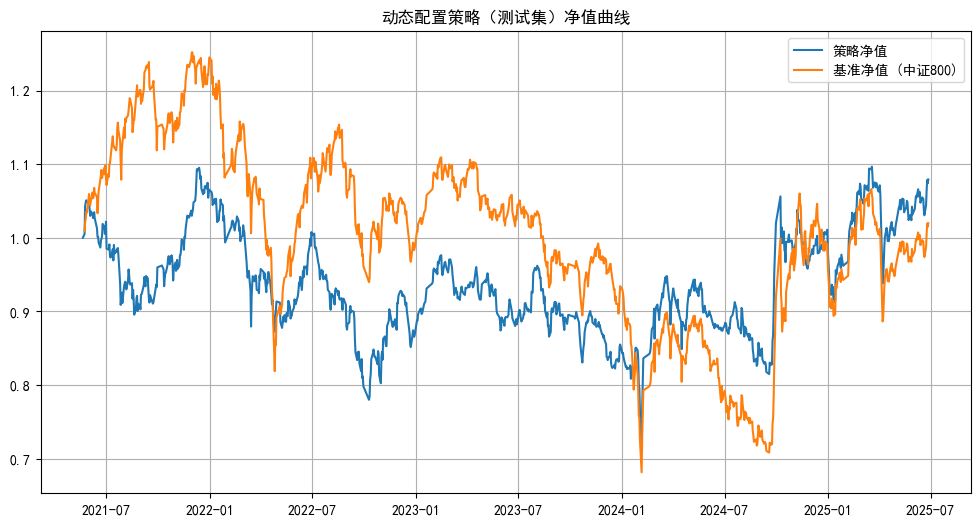

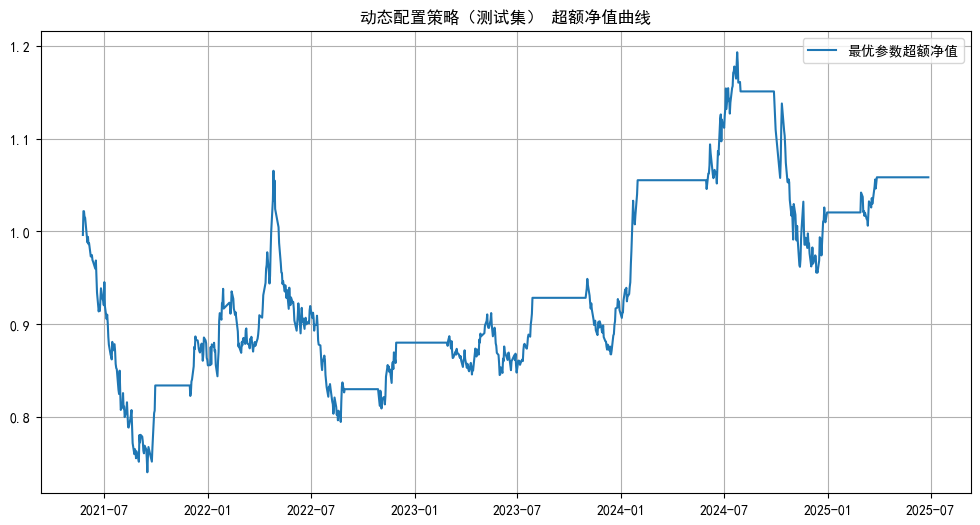

In [29]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_test2 = (1 + returns_1000_test2).cumprod()

# 计算超额净值曲线
excess_nav_test2 = portfolio_nav_test2 / benchmark_nav_test2


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test2.index, portfolio_nav_test2, label='策略净值')
plt.plot(benchmark_nav_test2.index, benchmark_nav_test2, label='基准净值 (中证800)')
plt.title('动态配置策略（测试集）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test2.index, excess_nav_test2, label='最优参数超额净值')
plt.title('动态配置策略（测试集） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

优化方向	
(A) 动态权重配置	根据两资产收益率差距动态调整仓位	
(B) 添加过滤条件	设定最小收益差阈值，只有差距足够大时才调仓		



动态权重反转

In [40]:
def reversal_strategy_dynamic_weight(df, window=60, scaling=20):
    """
    反转大小盘切换策略（月度调仓版，动态权重配置）

    参数:
    - df: DataFrame，包含 '50收益' 和 '中证1000全收益' 两列（收盘价）
    - window: int，计算反转信号的窗口期
    - scaling: float，控制权重分布陡峭程度

    返回:
    - position_df: DataFrame，包含 'position_50' 和 'position_1000' 两列，二者加总为1
    """

    # === 1) 计算过去window日收益率 ===
    r_50 = df['50收益'].pct_change(periods=window)
    r_1000 = df['中证1000全收益'].pct_change(periods=window)

    # === 2) 提取每月最后一个交易日 ===
    month_end_dates = df.resample('M').last().index

    # === 3) 初始化仓位 ===
    position_50 = pd.Series(index=df.index, dtype='float64')
    position_1000 = pd.Series(index=df.index, dtype='float64')

    # 初始默认仓位
    current_pos_50 = 0.5
    current_pos_1000 = 0.5

    # === 4) 根据信号更新仓位 ===
    for date in df.index:
        if date in month_end_dates:
            diff = r_50.loc[date] - r_1000.loc[date]
            # 使用sigmoid函数，将收益差映射到(0,1)
            weight_50 = 1 / (1 + np.exp(scaling * diff))
            weight_1000 = 1 - weight_50

            current_pos_50 = weight_50
            current_pos_1000 = weight_1000

        position_50.loc[date] = current_pos_50
        position_1000.loc[date] = current_pos_1000

    position_df = pd.DataFrame({
        'position_50': position_50,
        'position_1000': position_1000
    }, index=df.index)

    return position_df

In [41]:
# 获取策略每日仓位
position_df = reversal_strategy_dynamic_weight(df)

# =============================
# 计算每日组合收益率
# =============================
returns_50 = df['50收益'].pct_change()
returns_1000 = df['中证1000全收益'].pct_change()
portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
portfolio_returns = portfolio_returns.fillna(0)

# =============================
# 计算净值与超额净值曲线
# =============================
portfolio_nav = (1 + portfolio_returns).cumprod()
benchmark_nav = df['800收益'] / df['800收益'].iloc[0]
excess_nav = portfolio_nav / benchmark_nav

# =============================
# 计算回测指标
# =============================
annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
annual_vol = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol
max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
calmar_ratio = annual_return / abs(max_drawdown)

# =============================
# 输出结果
# =============================
print(f"【回测指标】")
print(f"年化收益率: {annual_return:.2%}")
print(f"年化波动率: {annual_vol:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")

【回测指标】
年化收益率: 11.57%
年化波动率: 26.36%
夏普比率: 0.44
最大回撤: -66.16%
Calmar Ratio: 0.17


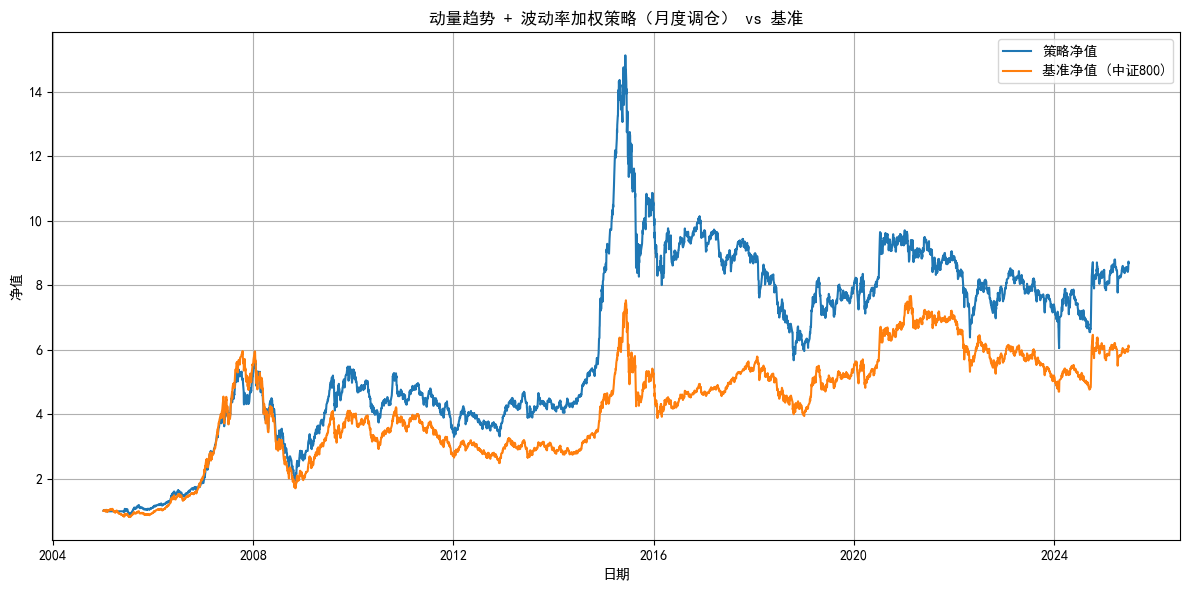

In [42]:
# 绘制净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav, label='策略净值')
plt.plot(benchmark_nav, label='基准净值 (中证800)')
plt.title('动量趋势 + 波动率加权策略（月度调仓） vs 基准')
plt.xlabel('日期')
plt.ylabel('净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

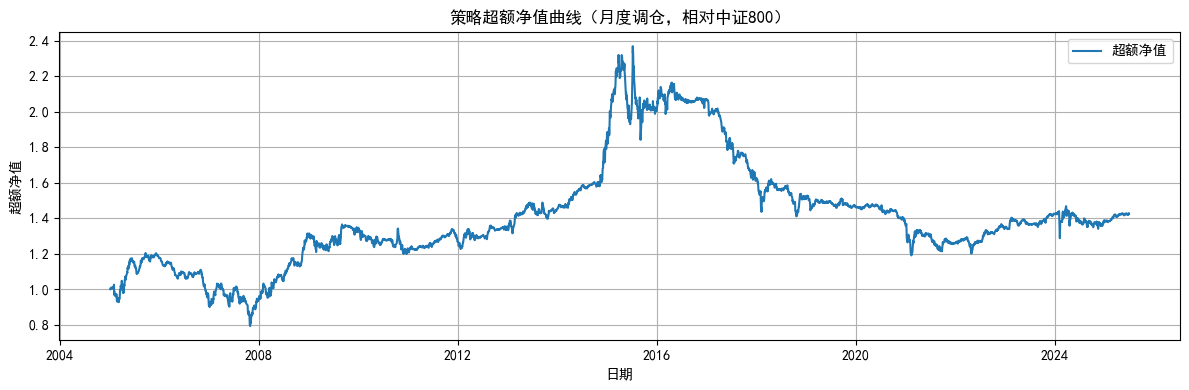

In [43]:
# 绘制超额净值曲线
plt.figure(figsize=(12,4))
plt.plot(excess_nav, label='超额净值')
plt.title('策略超额净值曲线（月度调仓，相对中证800）')
plt.xlabel('日期')
plt.ylabel('超额净值')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

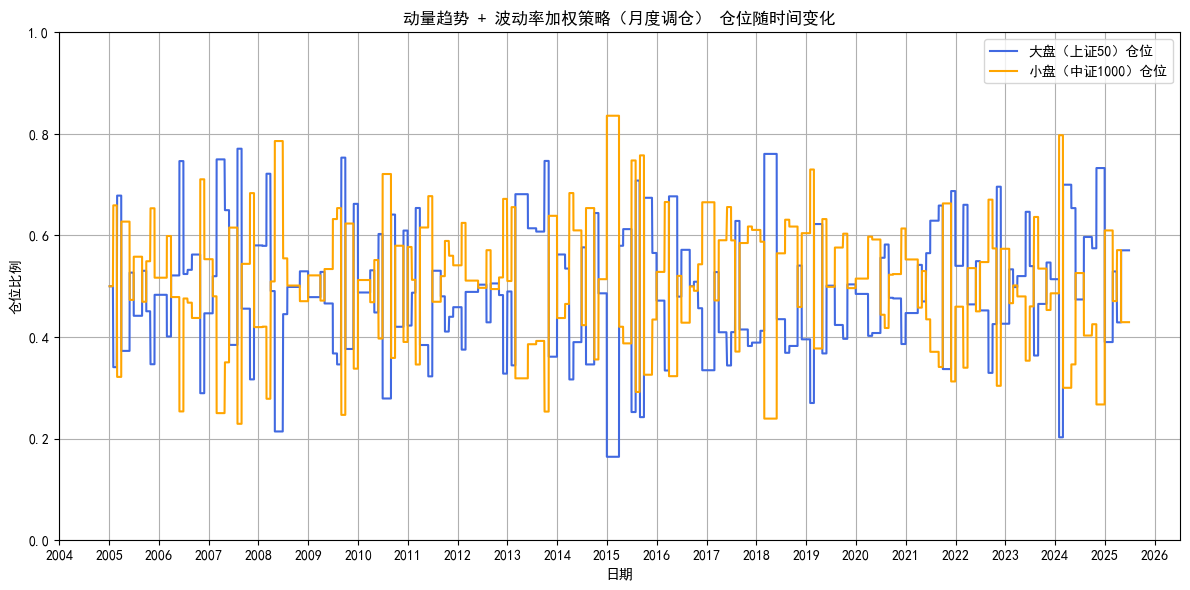

In [34]:
# 绘制仓位随时间变化图
plt.figure(figsize=(12,6))
plt.plot(position_df.index, position_df['position_50'], label='大盘（上证50）仓位', color='royalblue')
plt.plot(position_df.index, position_df['position_1000'], label='小盘（中证1000）仓位', color='orange')

plt.title('动量趋势 + 波动率加权策略（月度调仓） 仓位随时间变化')
plt.xlabel('日期')
plt.ylabel('仓位比例')
plt.ylim(0,1)  # 仓位比例限制在0-1之间
plt.legend()
plt.grid(True)

# 如果x轴过于密集，可使用以下代码仅显示每年刻度
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

In [35]:
# =============================
# 数据切分
# =============================

split_index_train = int(len(df) * 0.65)
split_index_val = int(len(df) * 0.8)

df_train = df.iloc[:split_index_train]
df_val = df.iloc[split_index_train:split_index_val]  # 验证集（测试集1）
df_test = df.iloc[split_index_val:]  # 测试集2

# =============================
# 参数范围
# =============================

window_range = [5, 10, 20, 30, 40, 50, 60]
scaling_range = [1, 3, 5, 10, 20]

# =============================
# Grid Search on Training Set
# =============================

results = []

for window, scaling in itertools.product(window_range, scaling_range):
    
    # 获取策略仓位（在训练集上）
    position_df = reversal_strategy_dynamic_weight(
        df_train,
        window=window,
        scaling=scaling
    )
    
    # 计算组合收益率
    returns_50 = df_train['50收益'].pct_change()
    returns_1000 = df_train['中证1000全收益'].pct_change()
    portfolio_returns = position_df['position_50'] * returns_50 + position_df['position_1000'] * returns_1000
    portfolio_returns = portfolio_returns.fillna(0)
    
    # 计算净值曲线
    portfolio_nav = (1 + portfolio_returns).cumprod()
    
    # 计算指标
    annual_return = portfolio_nav.iloc[-1] ** (252 / len(portfolio_nav)) - 1
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    max_drawdown = (portfolio_nav / portfolio_nav.cummax() - 1).min()
    calmar_ratio = annual_return / abs(max_drawdown)
    
    # 存储结果
    results.append({
        'window': window,
        'scaling': scaling,
        'annual_return': annual_return,
        'annual_vol': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    })

# =============================
# 输出 Top 10
# =============================

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='calmar_ratio', ascending=False)

print("【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】")
print(results_df_sorted.head(10))

【最佳参数组合 Top 10 (按 Calmar Ratio 排序)】
    window  scaling  annual_return  annual_vol  sharpe_ratio  max_drawdown  \
34      60       20       0.178246    0.288120      0.618651     -0.661618   
33      60       10       0.181737    0.281649      0.645261     -0.684028   
32      60        5       0.181766    0.277444      0.655145     -0.698090   
24      40       20       0.178005    0.285082      0.624400     -0.695353   
31      60        3       0.178420    0.276543      0.645179     -0.703333   
29      50       20       0.169107    0.290143      0.582841     -0.679702   
23      40       10       0.171528    0.280526      0.611450     -0.705004   
30      60        1       0.171134    0.277081      0.617633     -0.708293   
28      50       10       0.166549    0.283774      0.586906     -0.694815   
22      40        5       0.168278    0.278324      0.604611     -0.708794   

    calmar_ratio  
34      0.269408  
33      0.265687  
32      0.260377  
24      0.255992  
31      0.

In [36]:
# =============================
# 验证集（测试集1）评估
# =============================

best_params = results_df_sorted.iloc[0]

position_val = reversal_strategy_dynamic_weight(
    df_val,
    window=int(best_params['window']),
    scaling=best_params['scaling']
)

returns_50_val = df_val['50收益'].pct_change()
returns_1000_val = df_val['中证1000全收益'].pct_change()
portfolio_returns_val = position_val['position_50'] * returns_50_val + position_val['position_1000'] * returns_1000_val
portfolio_returns_val = portfolio_returns_val.fillna(0)
portfolio_nav_val = (1 + portfolio_returns_val).cumprod()

annual_return_val = portfolio_nav_val.iloc[-1] ** (252 / len(portfolio_nav_val)) - 1
annual_vol_val = portfolio_returns_val.std() * np.sqrt(252)
sharpe_ratio_val = annual_return_val / annual_vol_val
max_drawdown_val = (portfolio_nav_val / portfolio_nav_val.cummax() - 1).min()
calmar_ratio_val = annual_return_val / abs(max_drawdown_val)

print("\n【验证集（测试集1）表现】")
print(f"年化收益率: {annual_return_val:.2%}")
print(f"年化波动率: {annual_vol_val:.2%}")
print(f"夏普比率: {sharpe_ratio_val:.2f}")
print(f"最大回撤: {max_drawdown_val:.2%}")
print(f"Calmar Ratio: {calmar_ratio_val:.2f}")


【验证集（测试集1）表现】
年化收益率: 5.35%
年化波动率: 21.26%
夏普比率: 0.25
最大回撤: -28.43%
Calmar Ratio: 0.19


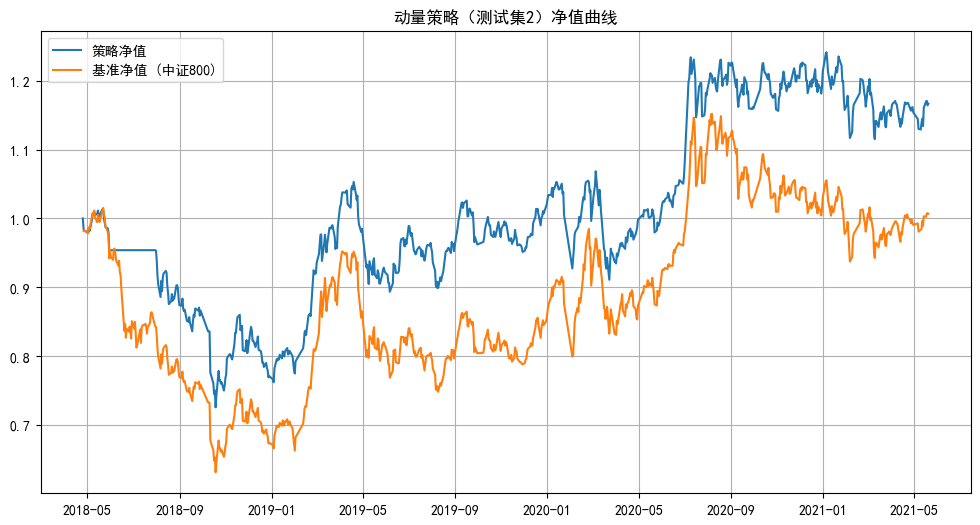

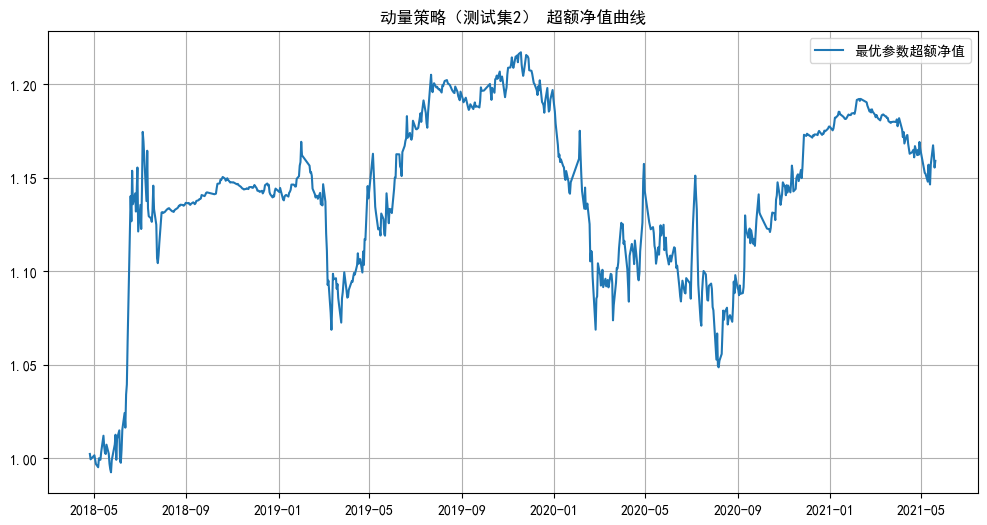

In [37]:
# 计算基准（例如中证1000）净值曲线
benchmark_nav_val = (1 + returns_1000_val).cumprod()

# 计算超额净值曲线
excess_nav_val = portfolio_nav_val / benchmark_nav_val


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_val.index, portfolio_nav_val, label='策略净值')
plt.plot(benchmark_nav_val.index, benchmark_nav_val, label='基准净值 (中证800)')
plt.title('动量策略（测试集2）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_val.index, excess_nav_val, label='最优参数超额净值')
plt.title('动量策略（测试集2） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# =============================
# 测试集2 评估
# =============================

position_test2 = reversal_strategy_dynamic_weight(
    df_test,
    window=int(best_params['window']),
    scaling=best_params['scaling']
)

returns_50_test2 = df_test['50收益'].pct_change()
returns_1000_test2 = df_test['中证1000全收益'].pct_change()
portfolio_returns_test2 = position_test2['position_50'] * returns_50_test2 + position_test2['position_1000'] * returns_1000_test2
portfolio_returns_test2 = portfolio_returns_test2.fillna(0)
portfolio_nav_test2 = (1 + portfolio_returns_test2).cumprod()

annual_return_test2 = portfolio_nav_test2.iloc[-1] ** (252 / len(portfolio_nav_test2)) - 1
annual_vol_test2 = portfolio_returns_test2.std() * np.sqrt(252)
sharpe_ratio_test2 = annual_return_test2 / annual_vol_test2
max_drawdown_test2 = (portfolio_nav_test2 / portfolio_nav_test2.cummax() - 1).min()
calmar_ratio_test2 = annual_return_test2 / abs(max_drawdown_test2)

print("\n【测试集2（最终测试集）表现】")
print(f"年化收益率: {annual_return_test2:.2%}")
print(f"年化波动率: {annual_vol_test2:.2%}")
print(f"夏普比率: {sharpe_ratio_test2:.2f}")
print(f"最大回撤: {max_drawdown_test2:.2%}")
print(f"Calmar Ratio: {calmar_ratio_test2:.2f}")


【测试集2（最终测试集）表现】
年化收益率: 1.79%
年化波动率: 19.76%
夏普比率: 0.09
最大回撤: -33.25%
Calmar Ratio: 0.05


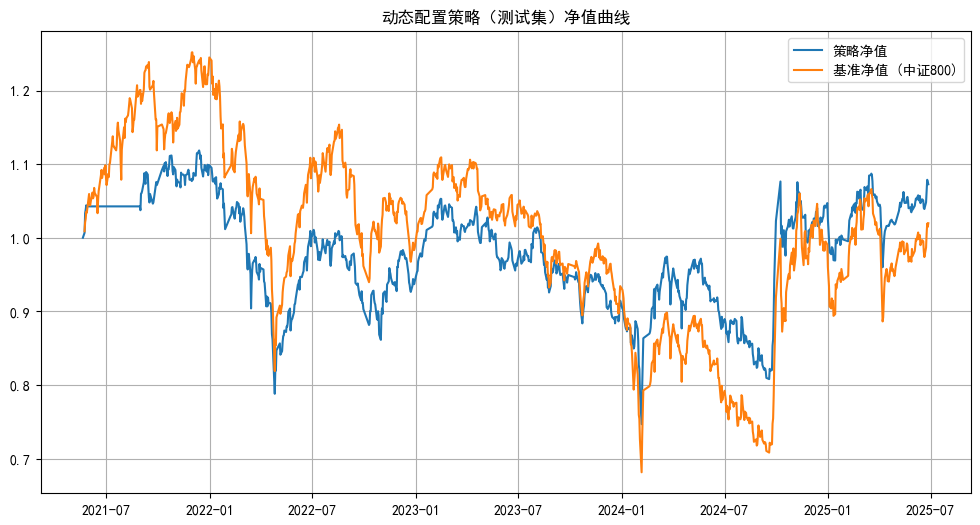

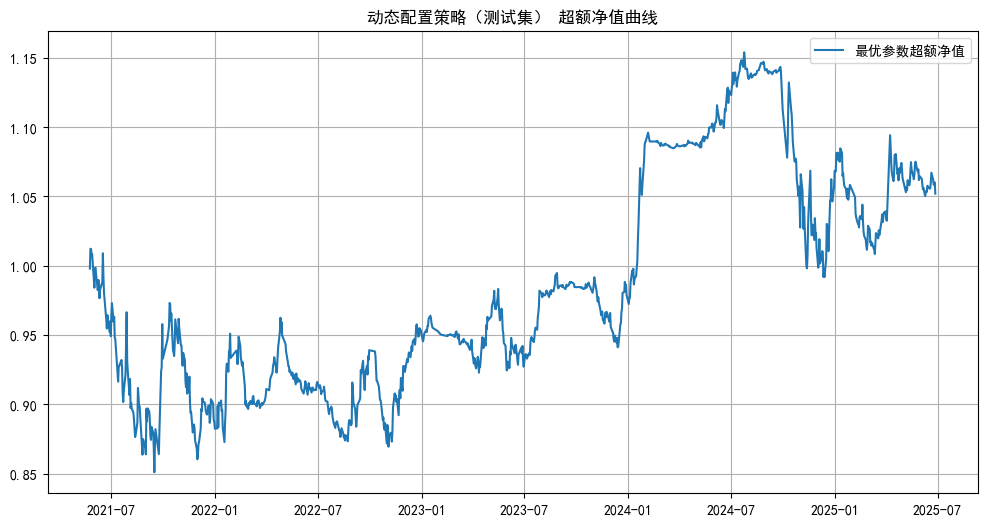

In [39]:
benchmark_nav_test2 = (1 + returns_1000_test2).cumprod()

# 计算超额净值曲线
excess_nav_test2 = portfolio_nav_test2 / benchmark_nav_test2


# 绘制策略 vs 基准净值曲线
plt.figure(figsize=(12,6))
plt.plot(portfolio_nav_test2.index, portfolio_nav_test2, label='策略净值')
plt.plot(benchmark_nav_test2.index, benchmark_nav_test2, label='基准净值 (中证800)')
plt.title('动态配置策略（测试集）净值曲线')
plt.legend()
plt.grid(True)
plt.show()

# 绘制超额净值曲线
plt.figure(figsize=(12,6))
plt.plot(excess_nav_test2.index, excess_nav_test2, label='最优参数超额净值')
plt.title('动态配置策略（测试集） 超额净值曲线')
plt.legend()
plt.grid(True)
plt.show()